# Imports

In [92]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime
import time
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import bigquery
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
from sklearn.model_selection import RandomizedSearchCV

# Download dataset from GCP

In [3]:
%reload_ext google.cloud.bigquery
client = bigquery.Client()

In [4]:
bqclient = bigquery.Client()

# Download query results.
query_string = """
select x.taxi_st_id,  substr(x.taxi_st_id,5) taxi_st_num,  x.taxi_count, x.taxi_update_time, x.weather_stn_id, c.rainfall, c.weather_update_time, x.mrt_stn_id, e.mrt_final_status, e.mrt_update_time
from (
select a.taxi_st_id, a.taxi_count, a.taxi_update_time, b.weather_stn_id, d.mrt_stn_id
from (
SELECT ts_id as taxi_st_id, taxi_count, cast(timestamp_trunc(timestamp, minute) as datetime) as taxi_update_time
FROM `taxi-compass-lewagon.api_dataset.h_taxi_stand_taxi_count`
WHERE timestamp > TIMESTAMP_SUB(CURRENT_TIMESTAMP() , INTERVAL 150 hour)
) a
left join
(
select weather_stn_id, taxi_st_id from `taxi-compass-lewagon.api_dataset.c_taxi_stand_weather_stn`
) b on a.taxi_st_id = b.taxi_st_id
left join 
(
select taxi_st_id, mrt_stn as mrt_stn_id from `taxi-compass-lewagon.api_dataset.c_mrt_stn_taxi_stand`
where mrt_stn is not null
) d on a.taxi_st_id = d.taxi_st_id
)x
left join 
(
select station_id as weather_stn_id, rainfall, datetime_trunc(datetime (update_time), minute) as weather_update_time
from `taxi-compass-lewagon.api_dataset.h_weather_rainfall`
where datetime(update_time) > datetime_SUB(CURRENT_DATETIME() , INTERVAL 150 hour)
) c on x.weather_stn_id = c.weather_stn_id and x.taxi_update_time = c.weather_update_time
left join
(
select stn_id as mrt_stn_id, final_status as mrt_final_status, datetime_trunc(datetime (update_time), minute) as mrt_update_time 
from `taxi-compass-lewagon.api_dataset.h_mrt_status_availability`
where datetime(update_time) > datetime_SUB(CURRENT_DATETIME() , INTERVAL 150 hour)
) e on x.taxi_update_time = e.mrt_update_time and x.mrt_stn_id = e.mrt_stn_id
"""

taxi_df = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        create_bqstorage_client=True,
    )
)
taxi_df.head()

,taxi_st_id,taxi_st_num,taxi_count,taxi_update_time,weather_stn_id,rainfall,weather_update_time,mrt_stn_id,mrt_final_status,mrt_update_time
0,kml_12,12,0,2022-01-15 14:09:00,S211,NaN,NaT,None,NaN,NaT
1,kml_13,13,0,2022-01-15 14:09:00,S226,NaN,NaT,None,NaN,NaT
2,kml_14,14,0,2022-01-15 14:09:00,S123,NaN,NaT,None,NaN,NaT
3,kml_19,19,0,2022-01-15 14:09:00,S36,NaN,NaT,NE12,1.0,2022-01-15 14:09:00
4,kml_19,19,0,2022-01-15 14:09:00,S36,NaN,NaT,CC13,1.0,2022-01-15 14:09:00


# Data Pre-processing

In [5]:
df = taxi_df[["taxi_st_num","taxi_update_time","taxi_count","rainfall","mrt_final_status"]].copy()
df["taxi_st_num"] = df["taxi_st_num"].astype('int64')
df = df.sort_values(by=["taxi_st_num", "taxi_update_time"],ascending=True).reset_index(drop=True)
df[["rainfall"]] = df[["rainfall"]].fillna(df.groupby(['taxi_st_num'])[["rainfall"]].ffill())
df[["mrt_final_status","rainfall"]] = df[["mrt_final_status","rainfall"]].fillna(value=0)
df

,taxi_st_num,taxi_update_time,taxi_count,rainfall,mrt_final_status
0,1,2022-01-09 00:40:00,0,0.0,0.0
1,1,2022-01-09 00:41:00,0,0.0,0.0
2,1,2022-01-09 00:42:00,3,0.0,0.0
3,1,2022-01-09 00:43:00,0,0.0,0.0
4,1,2022-01-09 00:44:00,2,0.0,0.0
...,...,...,...,...,...
3665393,350,2022-01-15 14:34:00,1,0.0,1.0
3665394,350,2022-01-15 14:35:00,1,0.0,1.0
3665395,350,2022-01-15 14:36:00,1,0.0,1.0
3665396,350,2022-01-15 14:37:00,1,0.0,1.0


In [6]:
df.taxi_count.value_counts(normalize=True)*100

0     27.040829
1     20.553239
2     14.919007
3     10.444405
4      7.375461
5      5.226145
6      3.701426
7      2.677281
8      1.937061
9      1.433296
10     1.074454
11     0.798249
12     0.607219
13     0.466689
14     0.360670
15     0.280270
16     0.222895
17     0.175315
18     0.135292
19     0.111584
20     0.086648
21     0.071452
22     0.060976
23     0.048753
24     0.038823
25     0.032493
26     0.025127
27     0.018961
28     0.017160
29     0.013887
30     0.010149
31     0.009140
32     0.006302
33     0.004256
34     0.003383
35     0.002510
36     0.001746
37     0.001446
38     0.001419
39     0.000982
40     0.000737
42     0.000600
41     0.000573
43     0.000464
44     0.000327
47     0.000191
49     0.000191
45     0.000164
46     0.000109
48     0.000082
51     0.000082
53     0.000027
50     0.000027
52     0.000027
Name: taxi_count, dtype: float64

In [7]:
100-27.16-20.59-14.9-10.4

26.950000000000003

In [8]:
def get_weekday(time):
    time = time.weekday()
    if time == 5 or time == 6:
        return 1
    return 0

In [9]:
df = df.groupby(["taxi_st_num","taxi_update_time","taxi_count","rainfall"]).agg('min').reset_index().drop_duplicates(
subset=['taxi_st_num','taxi_update_time'])
df = df.set_index(["taxi_st_num","taxi_update_time"])
df = df.groupby(level=0).apply(lambda x: x.reset_index(level=0, drop=True).asfreq("60S")).reset_index()
df[["taxi_count","rainfall","mrt_final_status"]] = df[["taxi_count","rainfall","mrt_final_status"]].fillna(df.groupby(['taxi_st_num'])[["taxi_count","rainfall","mrt_final_status"]].ffill())
df["hour"] = df["taxi_update_time"].dt.hour
df["minute"] = df["taxi_update_time"].dt.minute
df['hr_sin'] = np.sin(df["hour"]*(2.*np.pi/24))
df['hr_cos'] = np.cos(df["hour"]*(2.*np.pi/24))
df['min_sin'] = np.sin(df["minute"]*(2.*np.pi/60))
df['min_cos'] = np.cos(df["minute"]*(2.*np.pi/60))
df["taxi_update_time"] = df["taxi_update_time"].dt.tz_localize("Asia/Singapore")
df["weekend_bool"] = df.apply(lambda x : get_weekday(x["taxi_update_time"]), axis=1)
df

,taxi_st_num,taxi_update_time,taxi_count,rainfall,mrt_final_status,hour,minute,hr_sin,hr_cos,min_sin,min_cos,weekend_bool
0,1,2022-01-09 00:40:00+08:00,0.0,0.0,0.0,0,40,0.0,1.000000,-0.866025,-0.500000,1
1,1,2022-01-09 00:41:00+08:00,0.0,0.0,0.0,0,41,0.0,1.000000,-0.913545,-0.406737,1
2,1,2022-01-09 00:42:00+08:00,3.0,0.0,0.0,0,42,0.0,1.000000,-0.951057,-0.309017,1
3,1,2022-01-09 00:43:00+08:00,0.0,0.0,0.0,0,43,0.0,1.000000,-0.978148,-0.207912,1
4,1,2022-01-09 00:44:00+08:00,2.0,0.0,0.0,0,44,0.0,1.000000,-0.994522,-0.104528,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3317645,350,2022-01-15 14:34:00+08:00,1.0,0.0,1.0,14,34,-0.5,-0.866025,-0.406737,-0.913545,1
3317646,350,2022-01-15 14:35:00+08:00,1.0,0.0,1.0,14,35,-0.5,-0.866025,-0.500000,-0.866025,1
3317647,350,2022-01-15 14:36:00+08:00,1.0,0.0,1.0,14,36,-0.5,-0.866025,-0.587785,-0.809017,1
3317648,350,2022-01-15 14:37:00+08:00,1.0,0.0,1.0,14,37,-0.5,-0.866025,-0.669131,-0.743145,1


In [10]:
_ = np.array([])
len(_) == 0

X_train_mas = np.array([])
X_test_mas = np.array([])
y_train_mas = np.array([])
y_test_mas = np.array([])

In [14]:
bins = [0, 1, 2, 3, 4, 10000]
labels = [0, 1, 2, 3, 4]
for i in range(350):
    print(i+1,len(df.loc[df["taxi_st_num"] == i+1]), "started...")
    X = df.loc[df["taxi_st_num"] == i+1][["taxi_count", "rainfall","mrt_final_status",
                                          "weekend_bool","hr_sin","hr_cos","min_sin","min_cos"]].copy()
    X["y"] = X["taxi_count"].shift(-15)
    for day in range(1,15):
        X[f"taxi_count_+{15-day}"] = X["taxi_count"].shift(day-15)
    X = X.dropna()
    y = pd.cut(X["y"], bins=bins, right=False, labels=labels).to_numpy()
    X = X.drop(columns = ["y"]).to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, train_size=0.8)
    X_train = X_train.reshape(1, X_train.shape[0], X_train.shape[1])
    X_test = X_test.reshape(1, X_test.shape[0], X_test.shape[1])
    y_train = y_train.reshape(1, y_train.shape[0])
    y_test = y_test.reshape(1, y_test.shape[0])

    if len(X_train_mas) == 0:
        X_train_mas, X_test_mas, y_train_mas, y_test_mas = X_train, X_test, y_train, y_test
    else:
        X_train_mas = np.vstack((X_train_mas, X_train))
        X_test_mas = np.vstack((X_test_mas, X_test))
        y_train_mas = np.vstack((y_train_mas, y_train))
        y_test_mas = np.vstack((y_test_mas, y_test))
print(X_train_mas.shape, X_test_mas.shape, y_train_mas.shape, y_test_mas.shape)

1 9479 started...
2 9479 started...
3 9479 started...
4 9479 started...
5 9479 started...
6 9479 started...
7 9479 started...
8 9479 started...
9 9479 started...
10 9479 started...
11 9479 started...
12 9479 started...
13 9479 started...
14 9479 started...
15 9479 started...
16 9479 started...
17 9479 started...
18 9479 started...
19 9479 started...
20 9479 started...
21 9479 started...
22 9479 started...
23 9479 started...
24 9479 started...
25 9479 started...
26 9479 started...
27 9479 started...
28 9479 started...
29 9479 started...
30 9479 started...
31 9479 started...
32 9479 started...
33 9479 started...
34 9479 started...
35 9479 started...
36 9479 started...
37 9479 started...
38 9479 started...
39 9479 started...
40 9479 started...
41 9479 started...
42 9479 started...
43 9479 started...
44 9479 started...
45 9479 started...
46 9479 started...
47 9479 started...
48 9479 started...
49 9479 started...
50 9479 started...
51 9479 started...
52 9479 started...
53 9479 started...
54

# Model testing

In [ ]:
taxi_id_range=range(0,350)

## Ridge Classifier - 53.48%, 2.0s

Average accuracy is: 0.534765678062033. Standard deviation is 0.1420018643654237


(array([36., 76., 57., 65., 48., 23., 24., 13.,  2.,  6.]),
 array([0.3032224 , 0.37247755, 0.4417327 , 0.51098785, 0.580243  ,
        0.64949815, 0.7187533 , 0.78800845, 0.8572636 , 0.92651875,
        0.9957739 ]),
 <BarContainer object of 10 artists>)

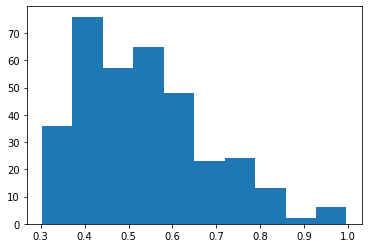

In [68]:
ridge_class_result_list=[]
for i in taxi_id_range:
    ridge_class = RidgeClassifier().fit(X_train_mas[i], y_train_mas[i])
    ridge_class_result_list.append(ridge_class.score(X_test_mas[i], y_test_mas[i]))
print(f"Average accuracy is: {np.mean(ridge_class_result_list)}. Standard deviation is {np.std(ridge_class_result_list)}")
plt.hist(ridge_class_result_list)

## K-Nearest Classifier - 51.35%, 1m30s

Model 0 of 350
Model 1 of 350
Model 2 of 350
Model 3 of 350
Model 4 of 350
Model 5 of 350
Model 6 of 350
Model 7 of 350
Model 8 of 350
Model 9 of 350
Model 10 of 350
Model 11 of 350
Model 12 of 350
Model 13 of 350
Model 14 of 350
Model 15 of 350
Model 16 of 350
Model 17 of 350
Model 18 of 350
Model 19 of 350
Model 20 of 350
Model 21 of 350
Model 22 of 350
Model 23 of 350
Model 24 of 350
Model 25 of 350
Model 26 of 350
Model 27 of 350
Model 28 of 350
Model 29 of 350
Model 30 of 350
Model 31 of 350
Model 32 of 350
Model 33 of 350
Model 34 of 350
Model 35 of 350
Model 36 of 350
Model 37 of 350
Model 38 of 350
Model 39 of 350
Model 40 of 350
Model 41 of 350
Model 42 of 350
Model 43 of 350
Model 44 of 350
Model 45 of 350
Model 46 of 350
Model 47 of 350
Model 48 of 350
Model 49 of 350
Model 50 of 350
Model 51 of 350
Model 52 of 350
Model 53 of 350
Model 54 of 350
Model 55 of 350
Model 56 of 350
Model 57 of 350
Model 58 of 350
Model 59 of 350
Model 60 of 350
Model 61 of 350
Model 62 of 350
Mo

(array([27., 77., 79., 67., 37., 20., 23., 12.,  2.,  6.]),
 array([0.2768093 , 0.34870576, 0.42060222, 0.49249868, 0.56439514,
        0.6362916 , 0.70818806, 0.78008452, 0.85198098, 0.92387744,
        0.9957739 ]),
 <BarContainer object of 10 artists>)

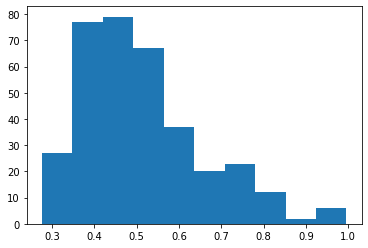

In [76]:
knc_result_list=[]
for i in taxi_id_range:
    knc_model = KNeighborsClassifier(n_neighbors=5).fit(X_train_mas[i], y_train_mas[i])
    print(f"Model {i+1} of 350")
    knc_result_list.append(knc_model.score(X_test_mas[i], y_test_mas[i]))
print(f"Average accuracy is: {np.mean(knc_result_list)}. Standard deviation is {np.std(knc_result_list)}")
plt.hist(knc_result_list)

## Decision Tree Classifier - 45.44%, 14.5s

Average accuracy is: 0.4543974039695118. Standard deviation is 0.13480162679267202


(array([70., 94., 80., 47., 17., 21., 11.,  3.,  2.,  5.]),
 array([0.27311146, 0.34506075, 0.41701004, 0.48895932, 0.56090861,
        0.6328579 , 0.70480718, 0.77675647, 0.84870576, 0.92065504,
        0.99260433]),
 <BarContainer object of 10 artists>)

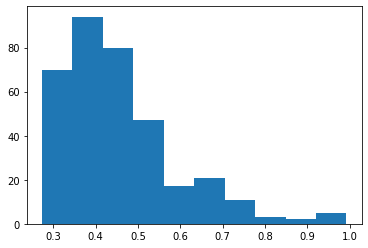

In [75]:
tree_result_list=[]
for i in taxi_id_range:
    tree_classifier = DecisionTreeClassifier(min_samples_split=2).fit(X_train_mas[i], y_train_mas[i])
    tree_result_list.append(tree_classifier.score(X_test_mas[i], y_test_mas[i]))
print(f"Average accuracy is: {np.mean(tree_result_list)}. Standard deviation is {np.std(tree_result_list)}")
plt.hist(tree_result_list)

## SVM Classifier - 54.47%, 13m48s

Model 0 of 350
Model 1 of 350
Model 2 of 350
Model 3 of 350
Model 4 of 350
Model 5 of 350
Model 6 of 350
Model 7 of 350
Model 8 of 350
Model 9 of 350
Model 10 of 350
Model 11 of 350
Model 12 of 350
Model 13 of 350
Model 14 of 350
Model 15 of 350
Model 16 of 350
Model 17 of 350
Model 18 of 350
Model 19 of 350
Model 20 of 350
Model 21 of 350
Model 22 of 350
Model 23 of 350
Model 24 of 350
Model 25 of 350
Model 26 of 350
Model 27 of 350
Model 28 of 350
Model 29 of 350
Model 30 of 350
Model 31 of 350
Model 32 of 350
Model 33 of 350
Model 34 of 350
Model 35 of 350
Model 36 of 350
Model 37 of 350
Model 38 of 350
Model 39 of 350
Model 40 of 350
Model 41 of 350
Model 42 of 350
Model 43 of 350
Model 44 of 350
Model 45 of 350
Model 46 of 350
Model 47 of 350
Model 48 of 350
Model 49 of 350
Model 50 of 350
Model 51 of 350
Model 52 of 350
Model 53 of 350
Model 54 of 350
Model 55 of 350
Model 56 of 350
Model 57 of 350
Model 58 of 350
Model 59 of 350
Model 60 of 350
Model 61 of 350
Model 62 of 350
Mo

(array([31., 75., 67., 67., 43., 24., 21., 13.,  3.,  6.]),
 array([0.31695721, 0.38483888, 0.45272055, 0.52060222, 0.58848389,
        0.65636556, 0.72424723, 0.7921289 , 0.86001057, 0.92789223,
        0.9957739 ]),
 <BarContainer object of 10 artists>)

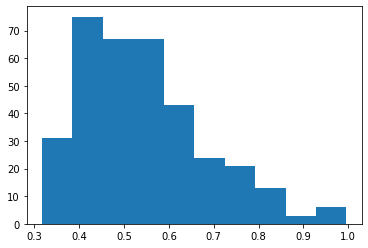

In [79]:
svc_result_list=[]
for i in taxi_id_range:
    svc_model = LinearSVC(C=1.0).fit(X_train_mas[i], y_train_mas[i])
    print(f"Model {i+1} of 350")
    svc_result_list.append(svc_model.score(X_test_mas[i], y_test_mas[i]))
print(f"Average accuracy is: {np.mean(svc_result_list)}. Standard deviation is {np.std(svc_result_list)}")
plt.hist(svc_result_list)

## Gaussian Naive Bayes Classifer - 46.46%, 1.3s

Average accuracy is: 0.4646109727567731. Standard deviation is 0.1118471561611818


(array([  1.,   0.,   4.,  92., 125.,  72.,  28.,  18.,   3.,   7.]),
 array([0.04965663, 0.13497095, 0.22028526, 0.30559958, 0.39091389,
        0.47622821, 0.56154253, 0.64685684, 0.73217116, 0.81748547,
        0.90279979]),
 <BarContainer object of 10 artists>)

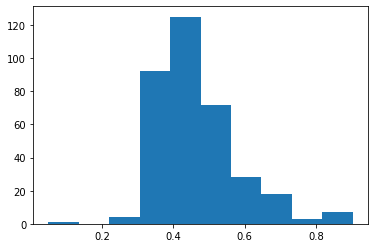

In [87]:
gaussian_nb_result_list=[]
for i in taxi_id_range:
    gaussian_nb = GaussianNB().fit(X_train_mas[i], y_train_mas[i])
    gaussian_nb_result_list.append(gaussian_nb.score(X_test_mas[i], y_test_mas[i]))
print(f"Average accuracy is: {np.mean(gaussian_nb_result_list)}. Standard deviation is {np.std(gaussian_nb_result_list)}")
plt.hist(gaussian_nb_result_list)

Multinomial NB and Categorical NB models were also trialled, but unable to run due to negative values present in time converted data. 

## Random Forest Classifier - 55.76%, 4m39s

Model 1 of 350
Model 2 of 350
Model 3 of 350
Model 4 of 350
Model 5 of 350
Model 6 of 350
Model 7 of 350
Model 8 of 350
Model 9 of 350
Model 10 of 350
Model 11 of 350
Model 12 of 350
Model 13 of 350
Model 14 of 350
Model 15 of 350
Model 16 of 350
Model 17 of 350
Model 18 of 350
Model 19 of 350
Model 20 of 350
Model 21 of 350
Model 22 of 350
Model 23 of 350
Model 24 of 350
Model 25 of 350
Model 26 of 350
Model 27 of 350
Model 28 of 350
Model 29 of 350
Model 30 of 350
Model 31 of 350
Model 32 of 350
Model 33 of 350
Model 34 of 350
Model 35 of 350
Model 36 of 350
Model 37 of 350
Model 38 of 350
Model 39 of 350
Model 40 of 350
Model 41 of 350
Model 42 of 350
Model 43 of 350
Model 44 of 350
Model 45 of 350
Model 46 of 350
Model 47 of 350
Model 48 of 350
Model 49 of 350
Model 50 of 350
Model 51 of 350
Model 52 of 350
Model 53 of 350
Model 54 of 350
Model 55 of 350
Model 56 of 350
Model 57 of 350
Model 58 of 350
Model 59 of 350
Model 60 of 350
Model 61 of 350
Model 62 of 350
Model 63 of 350
M

(array([17., 61., 76., 74., 55., 21., 24., 13.,  3.,  6.]),
 array([0.31801373, 0.38563127, 0.45324881, 0.52086635, 0.58848389,
        0.65610143, 0.72371896, 0.7913365 , 0.85895404, 0.92657158,
        0.99418912]),
 <BarContainer object of 10 artists>)

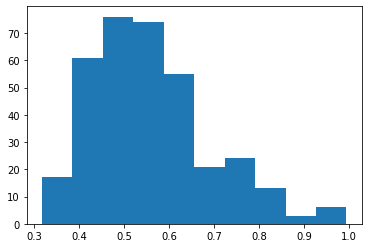

In [91]:
rfc_result_list=[]
for i in taxi_id_range:
    rfc_model = RandomForestClassifier().fit(X_train_mas[i], y_train_mas[i])
    print(f"Model {i+1} of 350")
    rfc_result_list.append(rfc_model.score(X_test_mas[i], y_test_mas[i]))
print(f"Average accuracy is: {np.mean(rfc_result_list)}. Standard deviation is {np.std(rfc_result_list)}")
plt.hist(rfc_result_list)

In [141]:
print(np.linspace(1,10,10))
print(range(1,10))
print(np.arange(1,10))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
range(1, 10)
[1 2 3 4 5 6 7 8 9]


In [149]:
rfc_model = RandomForestClassifier()
params = {
    'n_estimators':np.arange(20,200,40),
    'max_depth':np.arange(1,10),
    'min_samples_split':[2,5,10],
    'min_samples_leaf':np.arange(1,4),
    'max_features':['auto','sqrt'],
    'bootstrap':[True,False]
}

best_params_df=pd.DataFrame(columns=params.keys())

for i in taxi_id_range:
    print(f"Model {i+1} of 350")
    search = RandomizedSearchCV(rfc_model, 
                                params, 
                                random_state=0,
                                n_iter=25,
                                cv=5,n_jobs=-1)
    search.fit(X_train_mas[i], y_train_mas[i])
    best_temp_df = pd.DataFrame.from_dict(search.best_params_, orient='index').T
    best_params_df = pd.concat((best_params_df, best_temp_df))
best_params_df

Model 1 of 350
Model 2 of 350
Model 3 of 350
Model 4 of 350
Model 5 of 350
Model 6 of 350
Model 7 of 350
Model 8 of 350
Model 9 of 350
Model 10 of 350
Model 11 of 350
Model 12 of 350
Model 13 of 350
Model 14 of 350
Model 15 of 350
Model 16 of 350
Model 17 of 350
Model 18 of 350
Model 19 of 350
Model 20 of 350
Model 21 of 350
Model 22 of 350
Model 23 of 350
Model 24 of 350
Model 25 of 350
Model 26 of 350
Model 27 of 350
Model 28 of 350
Model 29 of 350
Model 30 of 350
Model 31 of 350
Model 32 of 350
Model 33 of 350
Model 34 of 350
Model 35 of 350
Model 36 of 350
Model 37 of 350
Model 38 of 350
Model 39 of 350
Model 40 of 350
Model 41 of 350
Model 42 of 350
Model 43 of 350
Model 44 of 350
Model 45 of 350
Model 46 of 350
Model 47 of 350
Model 48 of 350
Model 49 of 350
Model 50 of 350
Model 51 of 350
Model 52 of 350
Model 53 of 350
Model 54 of 350
Model 55 of 350
Model 56 of 350
Model 57 of 350
Model 58 of 350
Model 59 of 350
Model 60 of 350
Model 61 of 350
Model 62 of 350
Model 63 of 350
M

,n_estimators,max_depth,min_samples_split,min_samples_leaf,max_features,bootstrap
0,180,8,10,1,sqrt,False
0,60,6,5,2,sqrt,False
0,100,7,10,1,sqrt,True
0,180,6,5,3,auto,False
0,180,6,2,3,sqrt,True
...,...,...,...,...,...,...
0,20,3,10,1,auto,False
0,60,6,2,3,sqrt,True
0,100,5,10,2,auto,False
0,180,3,2,1,sqrt,True


In [151]:
for col in best_params_df.columns:
    print(best_params_df[col].value_counts())

180    128
60     104
100     74
140     29
20      15
Name: n_estimators, dtype: int64
6    151
7     76
3     56
5     34
8     23
1      5
9      5
Name: max_depth, dtype: int64
10    174
2      95
5      81
Name: min_samples_split, dtype: int64
2    134
3    126
1     90
Name: min_samples_leaf, dtype: int64
auto    201
sqrt    149
Name: max_features, dtype: int64
True     217
False    133
Name: bootstrap, dtype: int64


Model 1 of 350
Model 2 of 350
Model 3 of 350
Model 4 of 350
Model 5 of 350
Model 6 of 350
Model 7 of 350
Model 8 of 350
Model 9 of 350
Model 10 of 350
Model 11 of 350
Model 12 of 350
Model 13 of 350
Model 14 of 350
Model 15 of 350
Model 16 of 350
Model 17 of 350
Model 18 of 350
Model 19 of 350
Model 20 of 350
Model 21 of 350
Model 22 of 350
Model 23 of 350
Model 24 of 350
Model 25 of 350
Model 26 of 350
Model 27 of 350
Model 28 of 350
Model 29 of 350
Model 30 of 350
Model 31 of 350
Model 32 of 350
Model 33 of 350
Model 34 of 350
Model 35 of 350
Model 36 of 350
Model 37 of 350
Model 38 of 350
Model 39 of 350
Model 40 of 350
Model 41 of 350
Model 42 of 350
Model 43 of 350
Model 44 of 350
Model 45 of 350
Model 46 of 350
Model 47 of 350
Model 48 of 350
Model 49 of 350
Model 50 of 350
Model 51 of 350
Model 52 of 350
Model 53 of 350
Model 54 of 350
Model 55 of 350
Model 56 of 350
Model 57 of 350
Model 58 of 350
Model 59 of 350
Model 60 of 350
Model 61 of 350
Model 62 of 350
Model 63 of 350
M

(array([22., 62., 75., 73., 51., 20., 26., 12.,  3.,  6.]),
 array([0.33491812, 0.4010037 , 0.46708928, 0.53317485, 0.59926043,
        0.66534601, 0.73143159, 0.79751717, 0.86360275, 0.92968833,
        0.9957739 ]),
 <BarContainer object of 10 artists>)

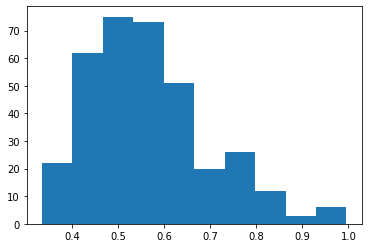

In [153]:
rfc_result_list=[]
for i in taxi_id_range:
    rfc_model = RandomForestClassifier(n_estimators=180,
                                       max_depth=6,
                                       min_samples_split=10,
                                       min_samples_leaf=2,
                                       max_features='auto',
                                       bootstrap=True
                                      ).fit(X_train_mas[i], y_train_mas[i])
    print(f"Model {i+1} of 350")
    rfc_result_list.append(rfc_model.score(X_test_mas[i], y_test_mas[i]))
print(f"Average accuracy is: {np.mean(rfc_result_list)}. Standard deviation is {np.std(rfc_result_list)}")
plt.hist(rfc_result_list)

### Tuned Random Forest Classifier - 56.5%, 3m35s

## XGboost Classifier - 54.00%, 11m31s

Model 0 of 350
Model 1 of 350
Model 2 of 350
Model 3 of 350
Model 4 of 350
Model 5 of 350
Model 6 of 350
Model 7 of 350
Model 8 of 350
Model 9 of 350
Model 10 of 350
Model 11 of 350
Model 12 of 350
Model 13 of 350
Model 14 of 350
Model 15 of 350
Model 16 of 350
Model 17 of 350
Model 18 of 350
Model 19 of 350
Model 20 of 350
Model 21 of 350
Model 22 of 350
Model 23 of 350
Model 24 of 350
Model 25 of 350
Model 26 of 350
Model 27 of 350
Model 28 of 350
Model 29 of 350
Model 30 of 350
Model 31 of 350
Model 32 of 350
Model 33 of 350
Model 34 of 350
Model 35 of 350
Model 36 of 350
Model 37 of 350
Model 38 of 350
Model 39 of 350
Model 40 of 350
Model 41 of 350
Model 42 of 350
Model 43 of 350
Model 44 of 350
Model 45 of 350
Model 46 of 350
Model 47 of 350
Model 48 of 350
Model 49 of 350
Model 50 of 350
Model 51 of 350
Model 52 of 350
Model 53 of 350
Model 54 of 350
Model 55 of 350
Model 56 of 350
Model 57 of 350
Model 58 of 350
Model 59 of 350
Model 60 of 350
Model 61 of 350
Model 62 of 350
Mo

(array([24., 74., 73., 66., 49., 21., 22., 12.,  3.,  6.]),
 array([0.30797676, 0.37675647, 0.44553619, 0.5143159 , 0.58309562,
        0.65187533, 0.72065504, 0.78943476, 0.85821447, 0.92699419,
        0.9957739 ]),
 <BarContainer object of 10 artists>)

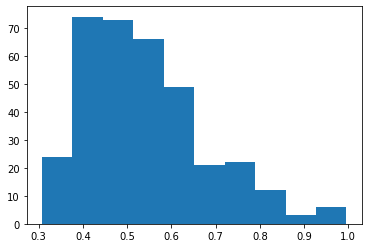

In [62]:
xgc_result_list=[]
warnings.filterwarnings('ignore')
for i in taxi_id_range:
    xgb = XGBClassifier(n_jobs=-1, 
#                         objective="multi:softprob", 
                        verbosity=0).fit(X_train_mas[i], y_train_mas[i])
    print(f"Model {i+1} of 350")
    xgc_result_list.append(xgb.score(X_test_mas[i], y_test_mas[i]))
print(f"Average accuracy is: {np.mean(xgc_result_list)}. Standard deviation is {np.std(xgc_result_list)}")
plt.hist(xgc_result_list)